`Autoencoders on  Fashion MNIST`

# 1. Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda')

### What is an Autoencoder?
An autoencoder is a type of neural network that learns to encoder given data into lower dimentional representaion and then decode it back to the original form.

### Structure
- **Encoder**: compress the input
- **decoder**: Reconstruct input from the latent space
  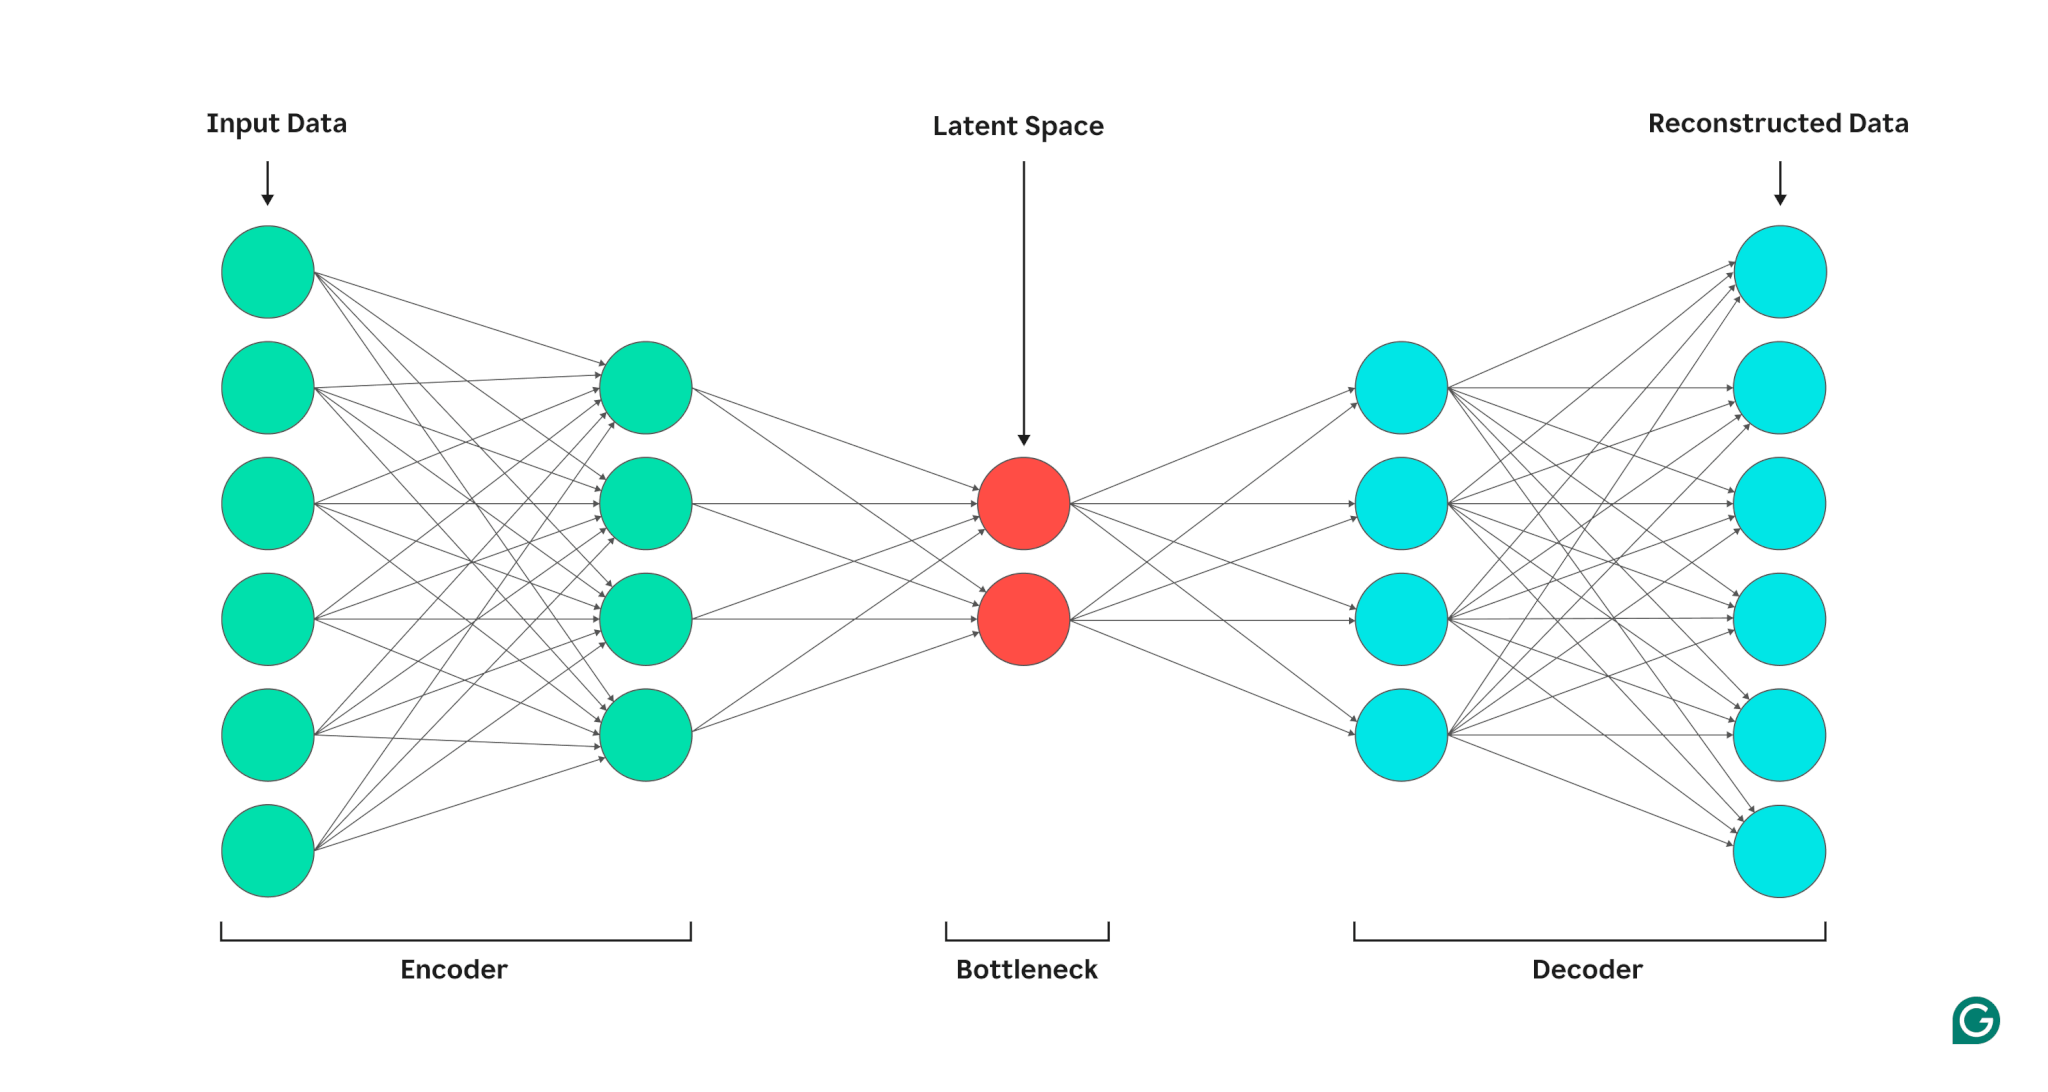
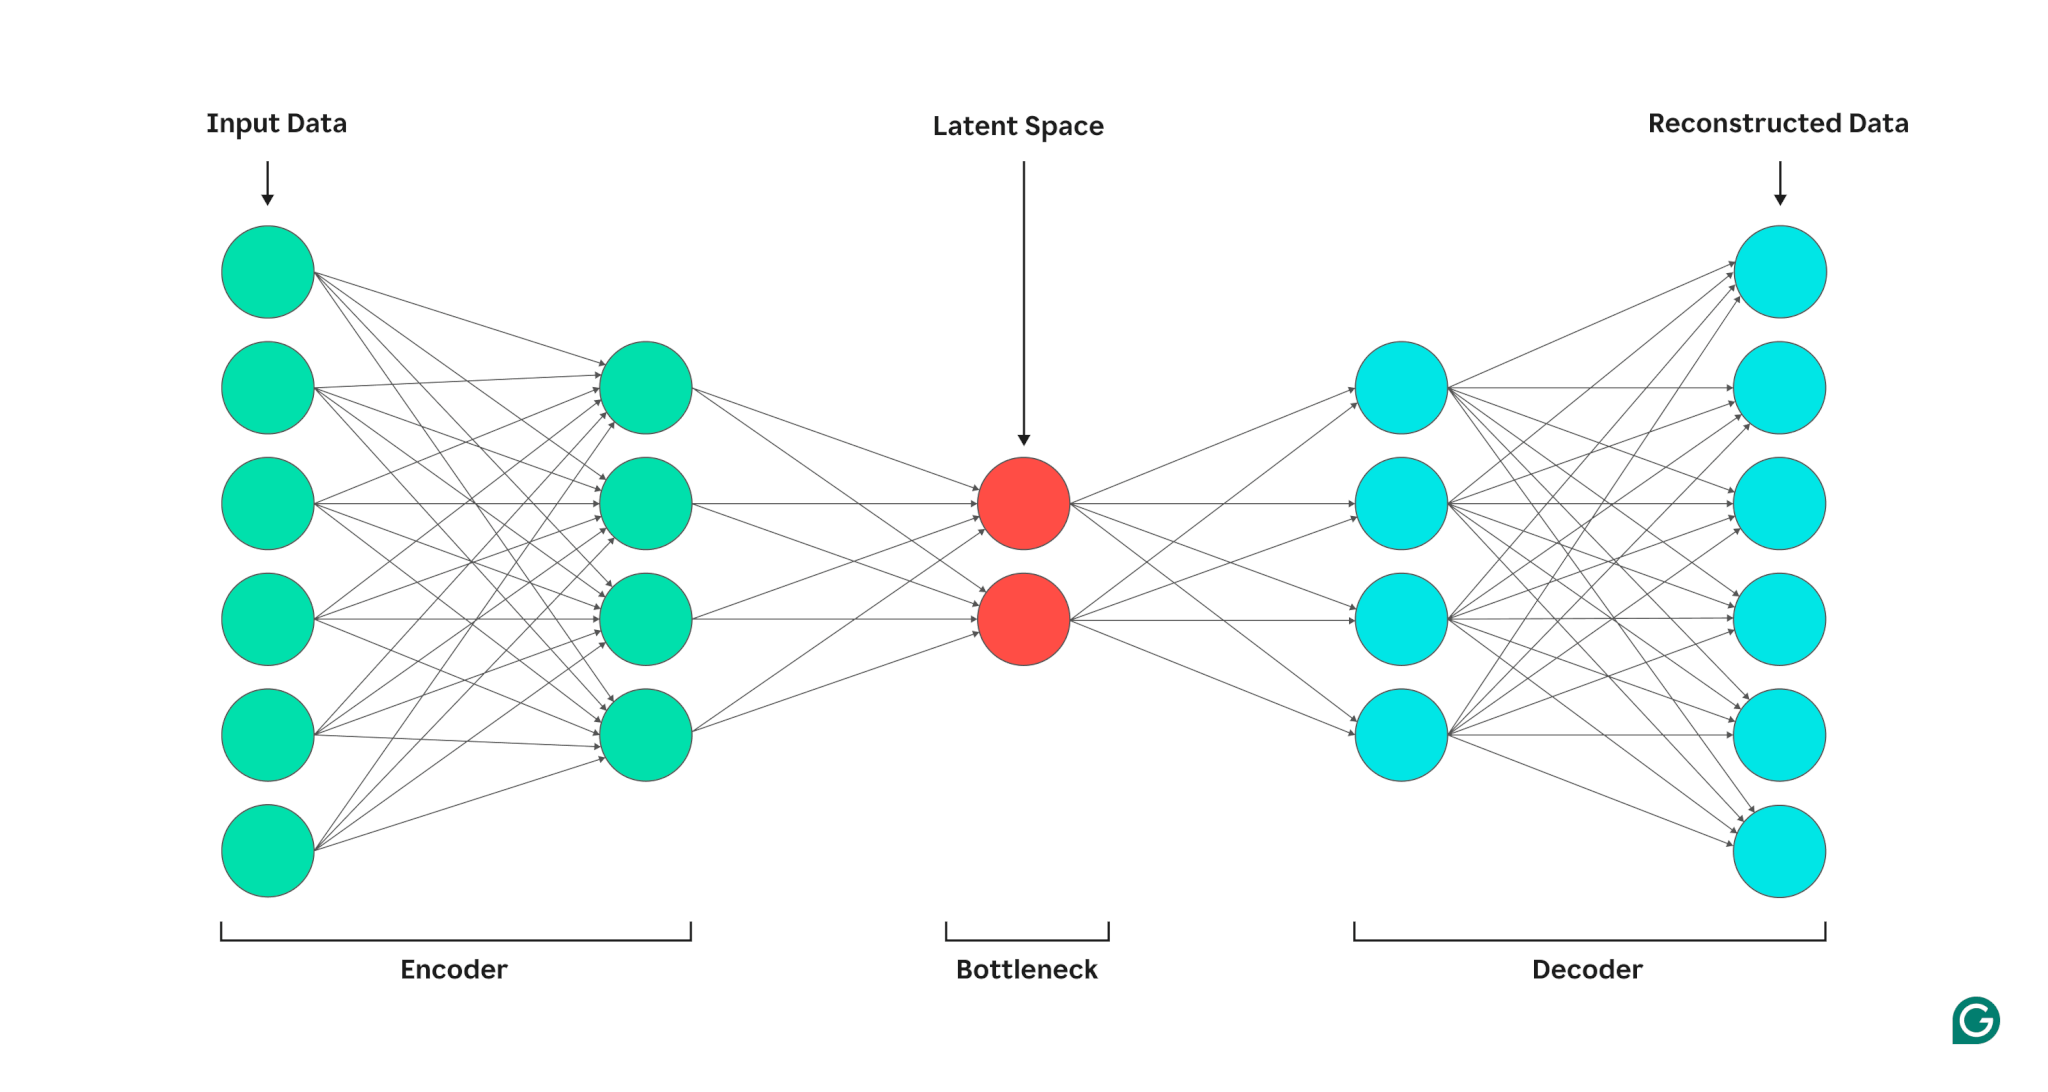

# 2. Load Fashion MNIST

In [2]:
# changes to normalised tensor
transform = transforms.ToTensor()

train = datasets.FashionMNIST(root='./data',train=True, download=True, transform=transform)
test = datasets.FashionMNIST(root='./data',train=False, download=True, transform=transform)

# Dataloaders
train_loader = DataLoader(train, batch_size=128, shuffle=True)
test_loader = DataLoader(test, batch_size=128, shuffle=False)

100%|██████████| 26.4M/26.4M [00:03<00:00, 8.24MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 137kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.64MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.9MB/s]


**Lets visualize some sample images**

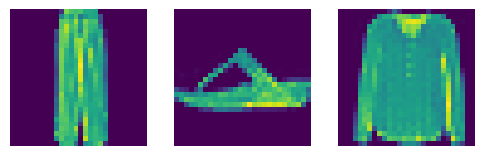

In [3]:
ex = iter(train_loader)
imgs, _ = next(ex)

plt.figure(figsize=(6, 2))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(imgs[i].squeeze())
    plt.axis('off')
plt.show()


# Autoencoder Model

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder (input: 1, 28, 28)
        self.encoder = nn.Sequential(
             nn.Flatten(),              # (1, 28, 28) -> (784,)
             nn.Linear(784, 256),       # Fully connected layer: 784 -> 256
             nn.ReLU(),                 # Activation
             nn.Linear(256, 64),         # Fully connected layer: 256 -> 64
             nn.ReLU(),                 # Activation
             nn.Linear(64, 16),         # Fully connected layer: 64 -> 16
             
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()           # Scale to 0 to 1 
        )
        
    def forward(self, x):
        encoded = self.encoder(x)         # compress input
        decoded = self.decoder(encoded)  # reconstruct
        return decoded

In [5]:
# Move model to gpu
model = Autoencoder().to(device)

# MSE loss for pixel wise reconstruction
criterion = nn.MSELoss()

# Adma Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)



# Training code

In [6]:
def train(model, loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, _ in loader:
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images.view(images.size(0), -1)) # loss b/w flattened images
                    
            optimizer.zero_grad() # clear gradients
            loss.backward()       # backprop
            optimizer.step()      # update weights
              
            running_loss +=loss.item()
        print(f"Epoch: {epoch+1}/{epochs}, Loss: {running_loss/len(loader):.4f}")    
             

# Training the Autoenoder

In [7]:
train(model, train_loader, criterion, optimizer, epochs=10)

Epoch: 1/10, Loss: 0.0382
Epoch: 2/10, Loss: 0.0209
Epoch: 3/10, Loss: 0.0182
Epoch: 4/10, Loss: 0.0167
Epoch: 5/10, Loss: 0.0156
Epoch: 6/10, Loss: 0.0149
Epoch: 7/10, Loss: 0.0144
Epoch: 8/10, Loss: 0.0139
Epoch: 9/10, Loss: 0.0134
Epoch: 10/10, Loss: 0.0131


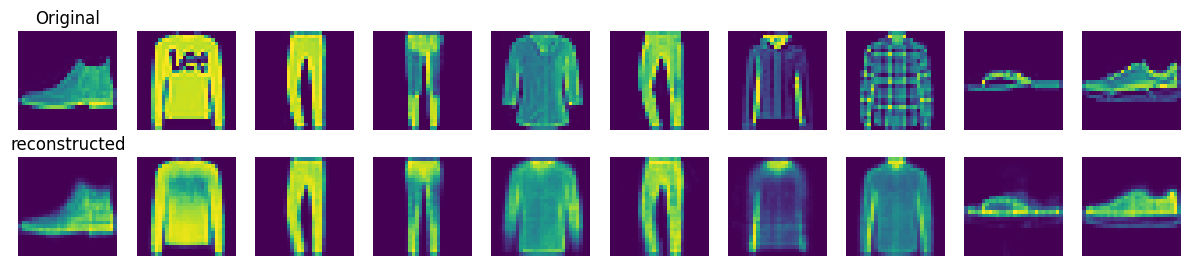

In [8]:
def show_recon(model, loader):
    model.eval()
    with torch.no_grad():
        dataiter = iter(loader)
        images, _ = next(dataiter)
        images = images[:10].to(device)
        reconstructed = model(images)
    fig, axs = plt.subplots(2, 10, figsize=(15,3))
    for i in range(10):
        axs[0, i].imshow(images[i].cpu().view(28,28))
        axs[1, i].imshow(reconstructed[i].cpu().view(28,28))
        axs[0,i].axis('off')
        axs[1, i].axis('off')
    axs[0,0].set_title('Original')
    axs[1,0].set_title("reconstructed")
    plt.show
show_recon(model, test_loader)

##  What else I can do next?

-  **Denoising Autoencoder**: Add noise to inputs and train to recover clean images.
-  **Convolutional Autoencoder**: Replace Linear layers with Conv2d and ConvTranspose2d.
-  **Anomaly Detection**: Train only on normal data, then detect high reconstruction loss as anomalies.
-  **Visualize Latent Space**: Use t-SNE or PCA on the 16-dim latent space.
